# Промышленность

Чтобы оптимизировать производственные расходы, металлургический комбинат ООО «Так закаляем сталь» решил уменьшить потребление электроэнергии на этапе обработки стали. Нам предстоит построить модель, которая предскажет температуру стали.

**Описание этапа обработки**

Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша. 

Из сплава выводится сера (десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (англ. tribe, «масса»).

Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.

Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. *slab*, «плита»).

## Предобработка данных

Импортируем необходимые библиотеки.

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, StackingRegressor
from sklearn.dummy import DummyRegressor

import time

### Знакомство с данными

Загрузим данные.

In [2]:
path = 'C:/Users/Влад/Downloads/final_steel/final_steel/'

data_arc = pd.read_csv(path + 'data_arc.csv')
data_bulk = pd.read_csv(path + 'data_bulk.csv')
data_bulk_time = pd.read_csv(path + 'data_bulk_time.csv')
data_gas = pd.read_csv(path + 'data_gas.csv')
data_temp = pd.read_csv(path + 'data_temp.csv')
data_wire = pd.read_csv(path + 'data_wire.csv')
data_wire_time = pd.read_csv(path + 'data_wire_time.csv')

Исследуем каждый из загруженных датасетов.

**data_arc**

Посмотрим на первые 5 строк.

In [3]:
data_arc.head()

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397


Данный датасет представляет содержит информацию о нагреве стали электродами. Имеются столбцы с активной мощностью (фактической мощностью) и реактивной мощностью (бесполезная мощность) [[источник]](https://khomovelectro.ru/articles/aktivnaya-reaktivnaya-i-polnaya-kazhushchayasya-moshchnosti.html).

Соответственно, из этого датасета будет расчитана полная мощность, которая была затрачена при нагреве стали дугой. Далее путем умножения полной мощности на время нагрева будет расчитана величина затраченной энергии на нагрев.

Опишем датасет.

In [4]:
data_arc.describe()

,key,Активная мощность,Реактивная мощность
count,14876.000000,14876.000000,14876.000000
mean,1615.220422,0.670441,0.452592
std,934.571502,0.408159,5.878702
min,1.000000,0.030002,-715.504924
25%,806.000000,0.395297,0.290991
50%,1617.000000,0.555517,0.415962
75%,2429.000000,0.857034,0.637371
max,3241.000000,3.731596,2.676388


Видно, что минимальное значение реактивной мощности составляет -715, что очень похоже на выброс.

Посмотрим на соответствующую строку.

In [5]:
data_arc[data_arc['Реактивная мощность'] < 0]

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
9780,2116,2019-07-24 00:44:48,2019-07-24 00:46:37,0.495782,-715.504924


Действительно, только в одном случае реактивная мощность была отрицательна, поэтому эти данные вполне можно посчитать за выброс.

**data_bulk**

Посмотрим на первые 5 строк.

In [6]:
data_bulk.head()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


По всей видимости, столбцы датасета представляют ту или иную добавку, а строки соответствуют объему добавки.

Опишем данные.

In [7]:
data_bulk.describe()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
count,3129.000000,252.000000,22.000000,1298.000000,1014.000000,77.000000,576.000000,25.000000,1.0,19.000000,176.000000,177.000000,2450.000000,18.000000,2806.000000,2248.000000
mean,1624.383509,39.242063,253.045455,113.879045,104.394477,107.025974,118.925347,305.600000,49.0,76.315789,83.284091,76.819209,260.471020,181.111111,170.284747,160.513345
std,933.337642,18.277654,21.180578,75.483494,48.184126,81.790646,72.057776,191.022904,NaN,21.720581,26.060347,59.655365,120.649269,46.088009,65.868652,51.765319
min,1.000000,10.000000,228.000000,6.000000,12.000000,11.000000,17.000000,47.000000,49.0,63.000000,24.000000,8.000000,53.000000,151.000000,16.000000,1.000000
25%,816.000000,27.000000,242.000000,58.000000,72.000000,70.000000,69.750000,155.000000,49.0,66.000000,64.000000,25.000000,204.000000,153.250000,119.000000,105.000000
50%,1622.000000,31.000000,251.500000,97.500000,102.000000,86.000000,100.000000,298.000000,49.0,68.000000,86.500000,64.000000,208.000000,155.500000,151.000000,160.000000
75%,2431.000000,46.000000,257.750000,152.000000,133.000000,132.000000,157.000000,406.000000,49.0,70.500000,102.000000,106.000000,316.000000,203.500000,205.750000,205.000000
max,3241.000000,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.0,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000


В целом не похоже, что в данных есть сильные выбросы.

**data_bulk_time**

Посмотрим на первые 5 строк.

In [8]:
data_bulk_time.head()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:21:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:03:52,NaN,2019-05-03 11:03:52,2019-05-03 11:03:52
1,2,NaN,NaN,NaN,2019-05-03 11:46:38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:40:20,NaN,2019-05-03 11:40:20,2019-05-03 11:40:20
2,3,NaN,NaN,NaN,2019-05-03 12:31:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:09:40,NaN,2019-05-03 12:09:40,2019-05-03 12:09:40
3,4,NaN,NaN,NaN,2019-05-03 12:48:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:41:24,NaN,2019-05-03 12:41:24,2019-05-03 12:41:24
4,5,NaN,NaN,NaN,2019-05-03 13:18:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:12:56,NaN,2019-05-03 13:12:56,2019-05-03 13:12:56


В данном датасете представлено время добавления той или иной добавки.

**data_gas**

Посмотрим на первые 5 строк.

In [9]:
data_gas.head()

,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


В датасете приведен объем инертного газа, которым продувалась сталь в процессе.

**data_temp**

Посмотрим на первые 5 строк.

In [10]:
data_temp.head()

,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0


Соответственно, в данном датасете представлена наша целевая переменная - температура стали в процессе обработки.

**data_wire**

Посмотрим на первые 5 строк.

In [11]:
data_wire.head()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


В данном датасете представлена информация о добавлении той или иной проволоки в сталь.

Опишем данные.

In [12]:
data_wire.describe()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
count,3081.000000,3055.000000,1079.000000,63.000000,14.000000,1.000,73.000000,11.000000,19.000000,29.000000
mean,1623.426485,100.895853,50.577323,189.482681,57.442841,15.132,48.016974,10.039007,53.625193,34.155752
std,932.996726,42.012518,39.320216,99.513444,28.824667,NaN,33.919845,8.610584,16.881728,19.931616
min,1.000000,1.918800,0.030160,0.144144,24.148801,15.132,0.034320,0.234208,45.076721,4.622800
25%,823.000000,72.115684,20.193680,95.135044,40.807002,15.132,25.053600,6.762756,46.094879,22.058401
50%,1619.000000,100.158234,40.142956,235.194977,45.234282,15.132,42.076324,9.017009,46.279999,30.066399
75%,2434.000000,126.060483,70.227558,276.252014,76.124619,15.132,64.212723,11.886057,48.089603,43.862003
max,3241.000000,330.314424,282.780152,385.008668,113.231044,15.132,180.454575,32.847674,102.762401,90.053604


В целом не похоже, что в данных есть выбросы.

**data_wire_time**

Посмотрим на первые 5 строк.

In [13]:
data_wire_time.head()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:11:41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:46:10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:13:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:48:05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:18:15,2019-05-03 13:32:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN


В датасете представлено время добавления той или иной проволоки в сталь.

**Вывод**:

На данном этапе были загружены и исследованы все датасеты.     
Во всех файлах столбец key содержит номер партии. В файлах может быть несколько строк с одинаковым значением key: они соответствуют разным итерациям обработки.

### Исследовательский анализ данных

На данном этапе проведем исследовательский анализ данных в датасете.

**Проверка корреляции добавок**

Для начала проверим, есть ли в датасете корреляция между добавками. Например, столбцы с добавками могут коррелировать, если вместе с одной добавкой всегда добавляют другую в пропорциональном количестве. Для этого построим график зависимостей всех столбцов между друг другом.

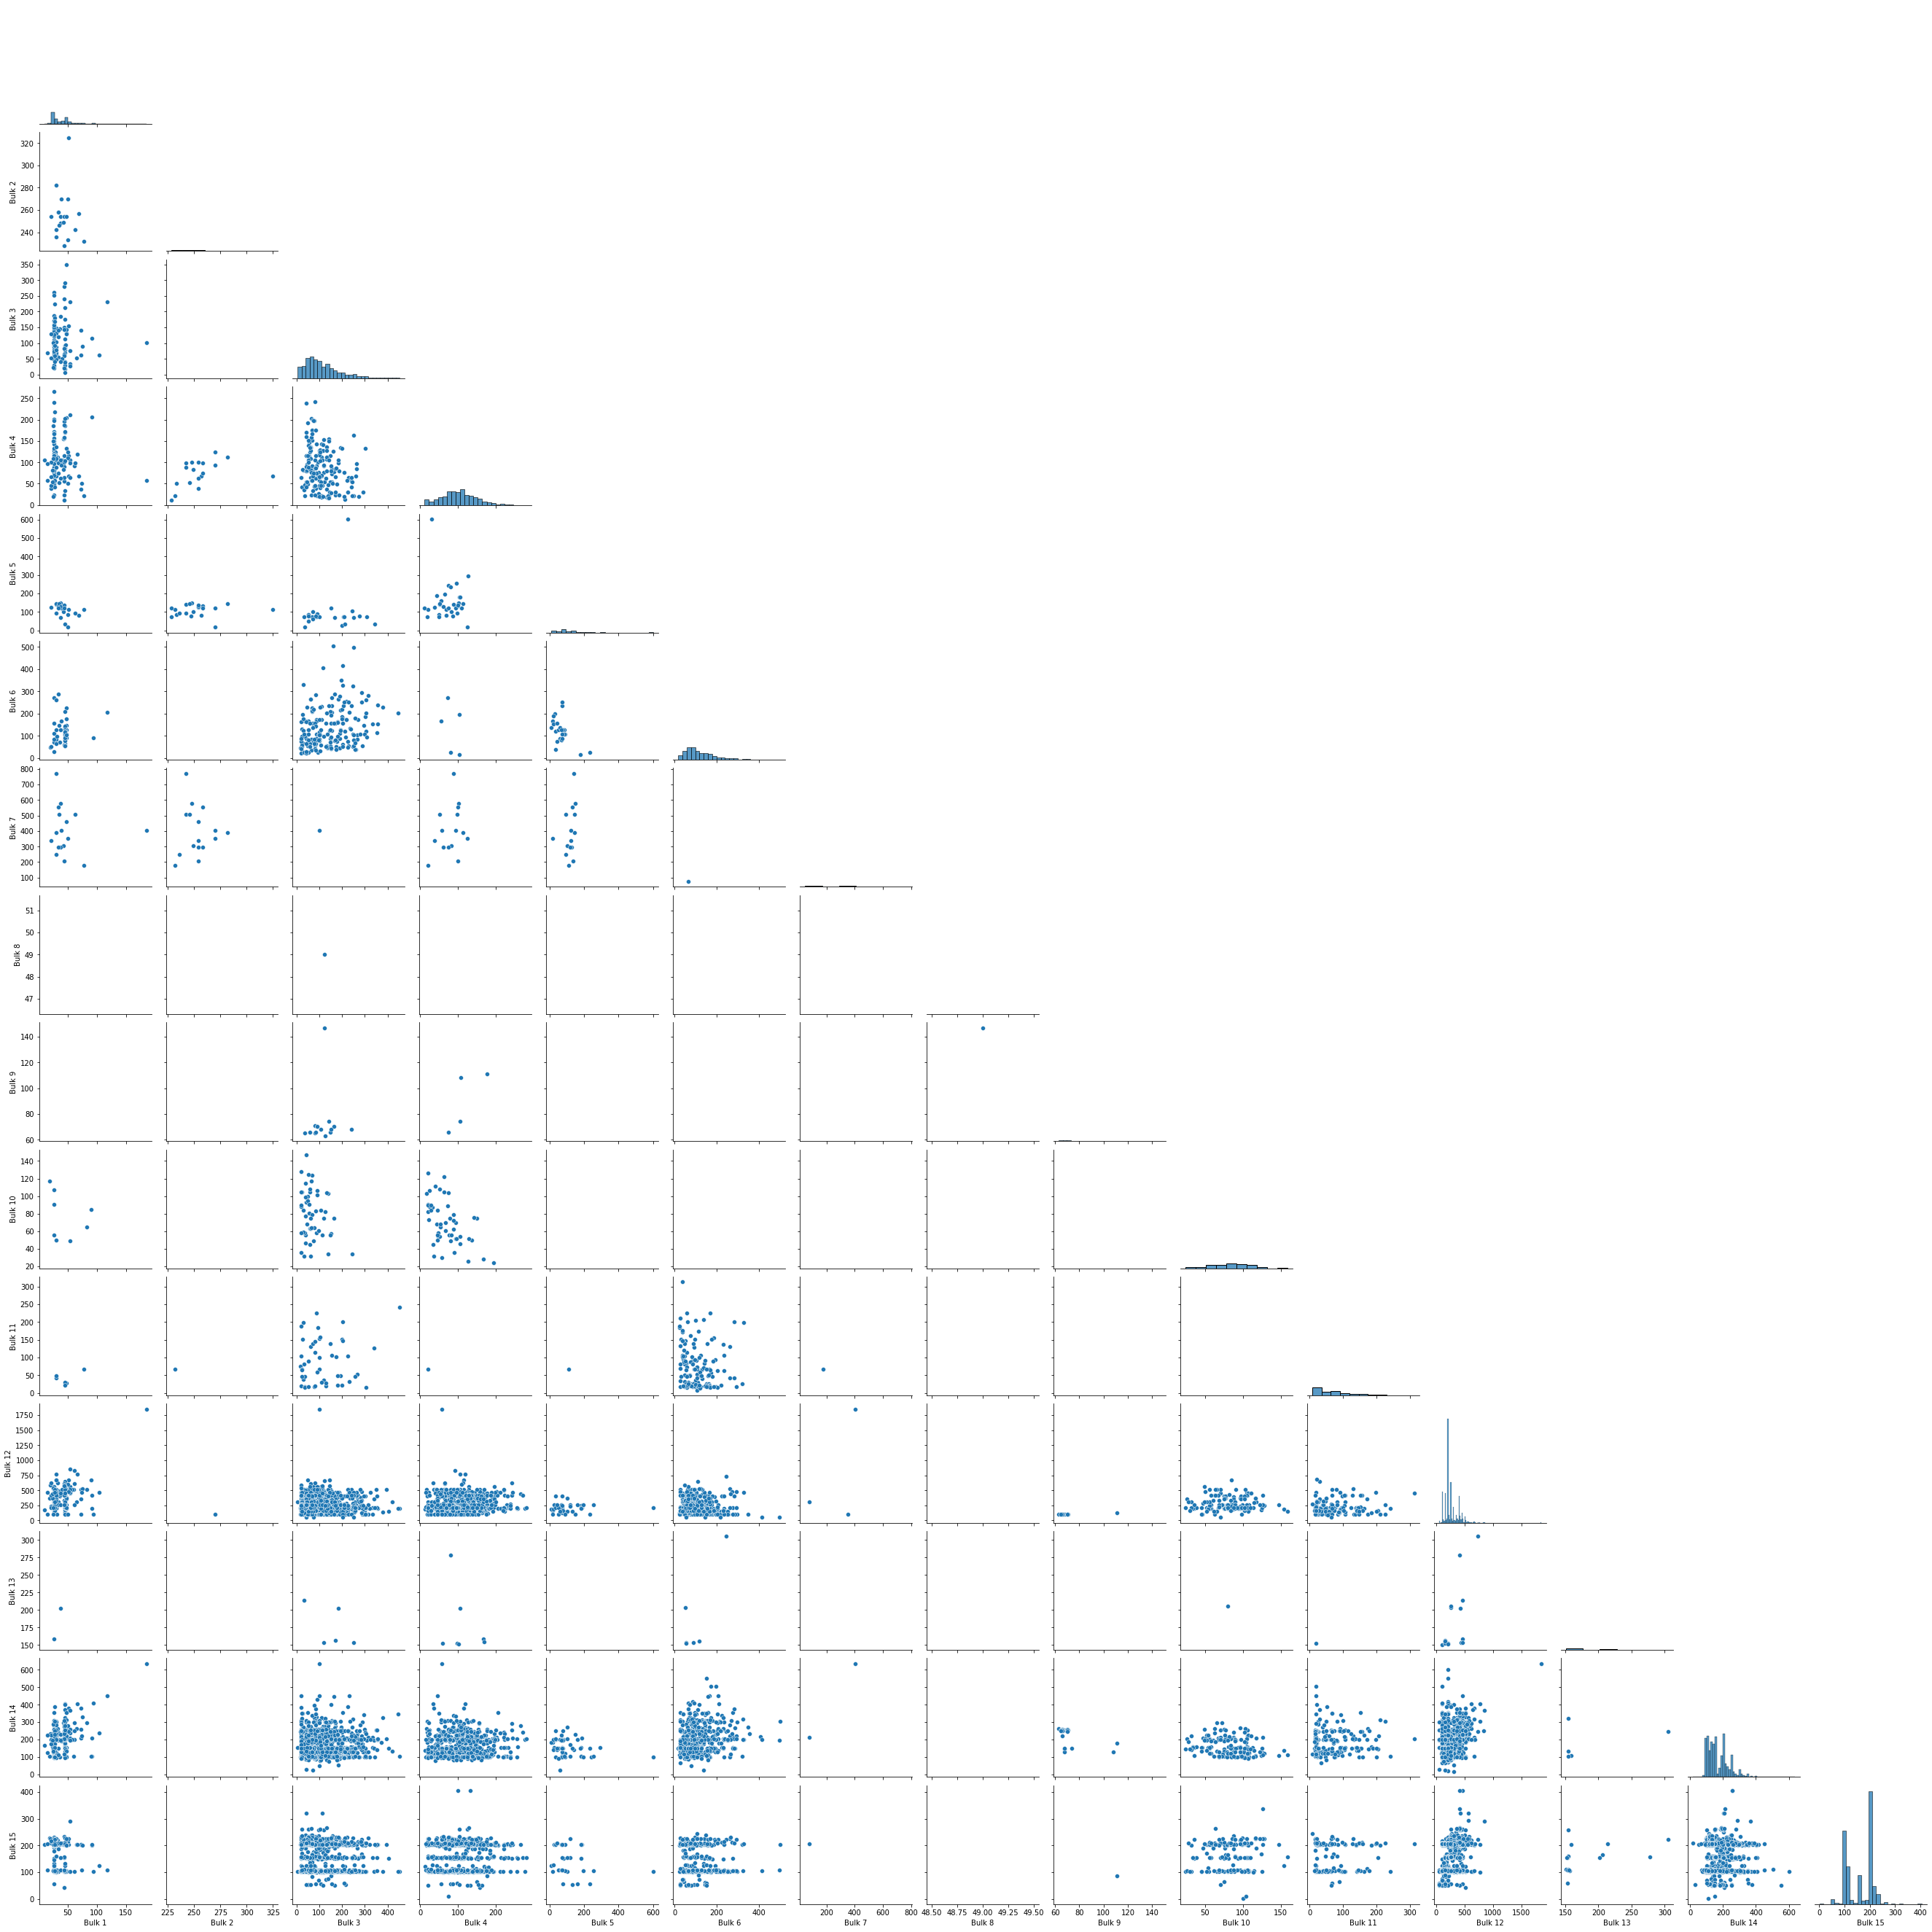

In [14]:
sns.pairplot(data_bulk.drop(columns=['key']), corner=True, diag_kind='hist')

На графиках видно, что в датасете нет явной корреляции между столбцами, поэтому нет смысла создавать новые столбцы на основе имеющихся.

**Проверка корреляции проволоки**

Теперь проверим корреляции столбцов с проволокой.

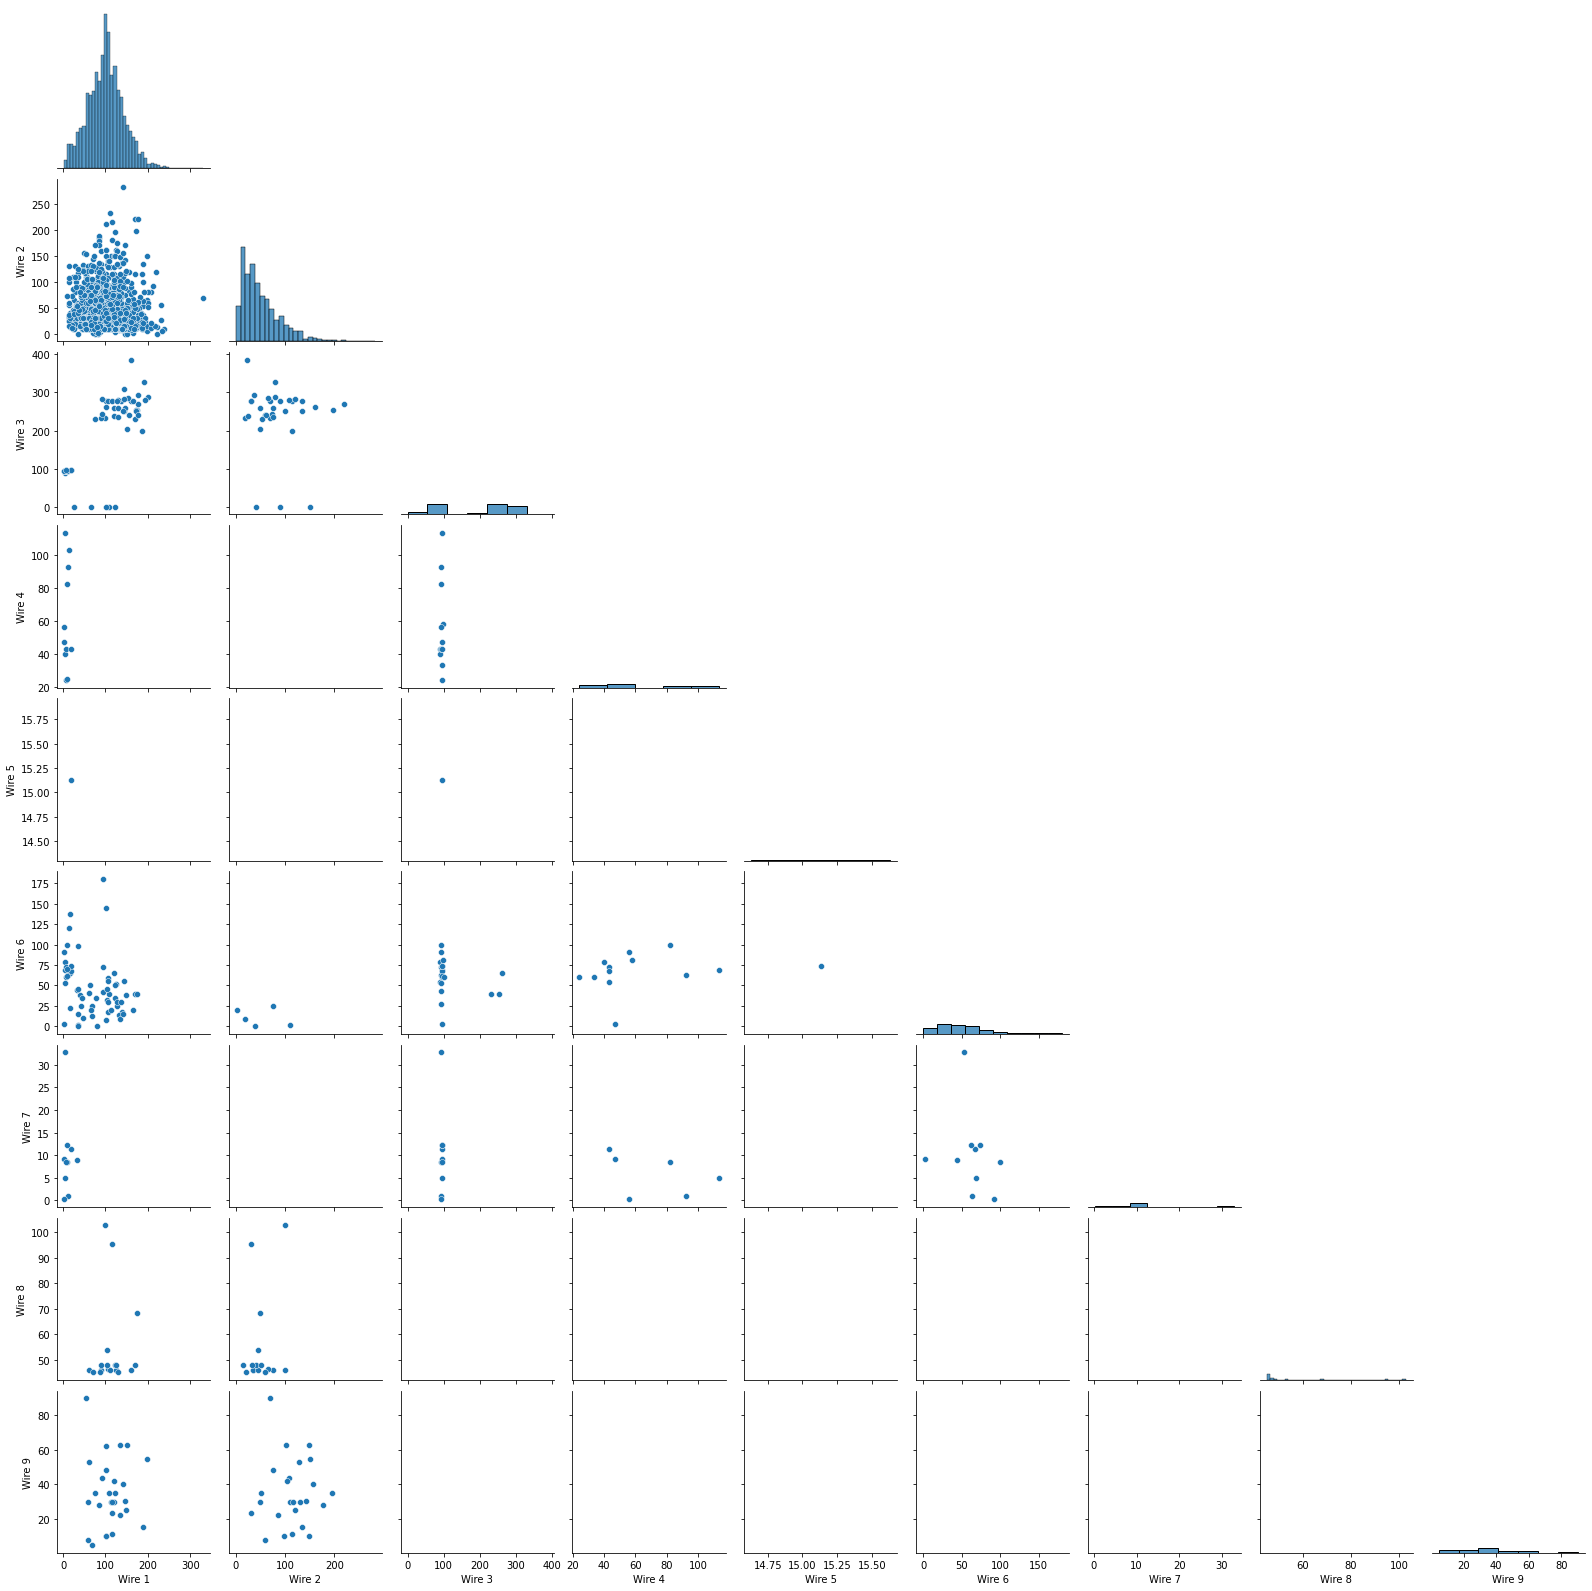

In [15]:
sns.pairplot(data_wire.drop(columns=['key']), corner=True, diag_kind='hist')

В данном случае также видно, что явной корреляции между столбцами нет.

**Проверка корреляции потраченной энергии с количеством продуваемого газа**

Известно, что при продувке стали инертным газом уменьшается его температура [[источник]](https://metallurgist.pro/produvka-metalla-inertnymi-gazami/).

То есть, в датасете может присутствовать корреляция между потраченной энергией и количеством продуваемого газа. Попробуем построить соответствующую зависимость.

Для начачла нам необходимо посчитать, какую энергию тратят на каждую итерацию, которой соответствует столбец 'key'.

Для этого необходимо посчитать полную мощность, а затем умножить ее на время нагрева [[источник]](https://khomovelectro.ru/articles/aktivnaya-reaktivnaya-i-polnaya-kazhushchayasya-moshchnosti.html).

Сначала посчитаем полную мощность в каждый этап нагрева, предварительно удалив всю итерацию, в которой было отрицательное значение реактивной мощности (итерация 2116).

In [16]:
data_arc = data_arc.drop(index=data_arc[data_arc['key'] == 2116].index)
data_arc['Полная мощность'] = np.sqrt(data_arc['Активная мощность'] ** 2 + data_arc['Реактивная мощность'] ** 2)

Теперь посчитаем длительность нагрева.

In [17]:
data_arc['Длительность нагрева'] = (pd.to_datetime(data_arc['Конец нагрева дугой']) - pd.to_datetime(data_arc['Начало нагрева дугой'])).dt.total_seconds()

Посчитаем затрачиваемую энергию.

In [18]:
data_arc['Энергия'] = data_arc['Полная мощность'] * data_arc['Длительность нагрева']

Сгруппируем данные по итерациям и просуммируем всю потраченную энергию.

In [19]:
data_arc_grouped = data_arc.groupby('key').agg({'Активная мощность':'sum', 'Реактивная мощность':'sum', 'Энергия':'sum'}).reset_index()

Теперь объединим полученный датасет с датасетом с количеством продуваемого газа по номеру итерации.

In [20]:
data_arc_grouped_gas_merged = data_arc_grouped.merge(data_gas, left_on='key', right_on='key', how='inner')

Построим график зависимости.

<AxesSubplot:xlabel='Газ 1', ylabel='Энергия'>

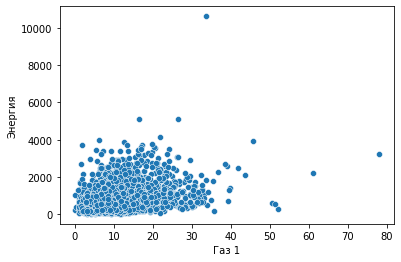

In [21]:
sns.scatterplot(data=data_arc_grouped_gas_merged, x='Газ 1', y='Энергия') 

Видно, что предположение не подтвердилось и корреляции между данными параметрами нет.

**Вывод:**

На данном этапе были проверены несколько предположений о корреляции между различными столбцами и корреляции между количеством продуваемого газа и затраченной энергии. Было выявлено, что явной корреляции между значениями нет.

## Создание модели

### Создание общей таблицы

Сначала запишем в таблицу с признаками датасет с полностью номером итерации и потраченной мощностью.

При этом надо помнить, что активная и реактивная мощности коррелируют с энергией, что очевидно, так как мы рассчитывали энергию из этих значений. Но предлагается не удалять значения активной и реактивной мощности, а добавить, например, соотношение между ними, так как чем больше реактивная мощность, тем бесполезнее потраченная энергия, что должно приводить к меньшей конечной температуре.

Посчитаем соответствующее значение и удалим исходные столбцы с мощностью.

In [22]:
data_arc_grouped['Отношение мощностей'] = data_arc_grouped['Реактивная мощность'] / data_arc_grouped['Активная мощность']

data = data_arc_grouped.drop(columns=['Реактивная мощность', 'Активная мощность'])

Добавим в датасет информацию о вводимых добавках, заменив при этом пропуски на 0.

При этом объединять будем только по пересекающимся итерациям, чтобы в датасете не было итераций без информации. 

In [23]:
data = data.merge(data_bulk.fillna(0), left_on='key', right_on='key', how='inner')

Добавим таким же образом информацию о вводимой проволоке.

In [24]:
data = data.merge(data_wire.fillna(0), left_on='key', right_on='key', how='inner')

Теперь добавим информацию о объеме продуваемого газа.

In [25]:
data = data.merge(data_gas.fillna(0), left_on='key', right_on='key', how='inner')

Добавим данные и первоначальной температуре.

In [26]:
data_first_temp = data_temp.groupby('key').agg({'Температура':'first'}).reset_index().rename(columns={'Температура':'Начальная температура'})
data = data.merge(data_first_temp.fillna(0), left_on='key', right_on='key', how='inner')

Добавим информацию о финальной температуре, сначала создав соответствующую таблицу.

In [27]:
data_final_temp = data_temp.groupby('key').agg({'Температура':'last'}).reset_index().rename(columns={'Температура':'Конечная температура'})
data = data.merge(data_final_temp.fillna(0), left_on='key', right_on='key', how='inner')

Наконец, добавим информацию об общем времени выдержки в минутах, то есть разницу между первым и последним измерением температуры.

In [28]:
data_duration = data_temp.groupby('key').agg({'Время замера':['first', 'last']}).reset_index()

data_duration['total'] = (pd.to_datetime(data_duration['Время замера']['last']) - pd.to_datetime(data_duration['Время замера']['first'])).dt.total_seconds() / 60

data_duration = data_duration.drop(columns='Время замера').droplevel(level=1, axis=1)

C:\Users\Влад\AppData\Local\Temp\ipykernel_18588\3983181352.py:5: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  data_duration = data_duration.drop(columns='Время замера').droplevel(level=1, axis=1)


In [29]:
data = data.merge(data_duration.fillna(0), left_on='key', right_on='key', how='inner')

Посмотрим на наш датасет.

In [30]:
data.head()

,key,Энергия,Отношение мощностей,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,...,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9,Газ 1,Начальная температура,Конечная температура,total
0,1,1442.377754,0.652551,0.0,0.0,0.0,43.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,29.749986,1571.0,1613.0,14.350000
1,2,881.233565,0.654561,0.0,0.0,0.0,73.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,12.555561,1581.0,1602.0,21.750000
2,3,525.066777,0.633076,0.0,0.0,0.0,34.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,28.554793,1596.0,1599.0,21.666667
3,4,796.911309,0.641987,0.0,0.0,0.0,81.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,18.841219,1601.0,1625.0,6.466667
4,5,1199.137958,0.672999,0.0,0.0,0.0,78.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,5.413692,1576.0,1602.0,12.700000


Переименуем наши столбцы в стиле Python.

In [31]:
new_cols = ['key', 'energy', 'power_relation'] + ['bulk_' + str(i) for i in range(1, 16)] + ['wire_' + str(i) for i in range(1, 10)] + ['gas', 'initial_temp', 'final_temp', 'total_time']
data.columns = new_cols

Посмотрим на таблицу еще раз.

In [32]:
data.head()

,key,energy,power_relation,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,...,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9,gas,initial_temp,final_temp,total_time
0,1,1442.377754,0.652551,0.0,0.0,0.0,43.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,29.749986,1571.0,1613.0,14.350000
1,2,881.233565,0.654561,0.0,0.0,0.0,73.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,12.555561,1581.0,1602.0,21.750000
2,3,525.066777,0.633076,0.0,0.0,0.0,34.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,28.554793,1596.0,1599.0,21.666667
3,4,796.911309,0.641987,0.0,0.0,0.0,81.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,18.841219,1601.0,1625.0,6.466667
4,5,1199.137958,0.672999,0.0,0.0,0.0,78.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,5.413692,1576.0,1602.0,12.700000


В датасете может быть проблема, что для итерации регистрировалась только одна температура, такие итерации нам не нужны.

Удалим строки, в которых начальная и конечная температура совпадают.

In [33]:
data = data.drop(index=data[data['initial_temp'] == data['final_temp']].index)

Также в датасете могут находиться итерации, в которых финальная температура ниже чем начальная.

Удалять такие строки мы не будем, так как с точки зрения физики такое возможно только при недостаточном нагреве, поэтому если мы оставим такие наблюдения, то наша модель сможет предсказывать и снижения температуры.

Посмотрим на корреляцию признаков в новой таблице.

<AxesSubplot:>

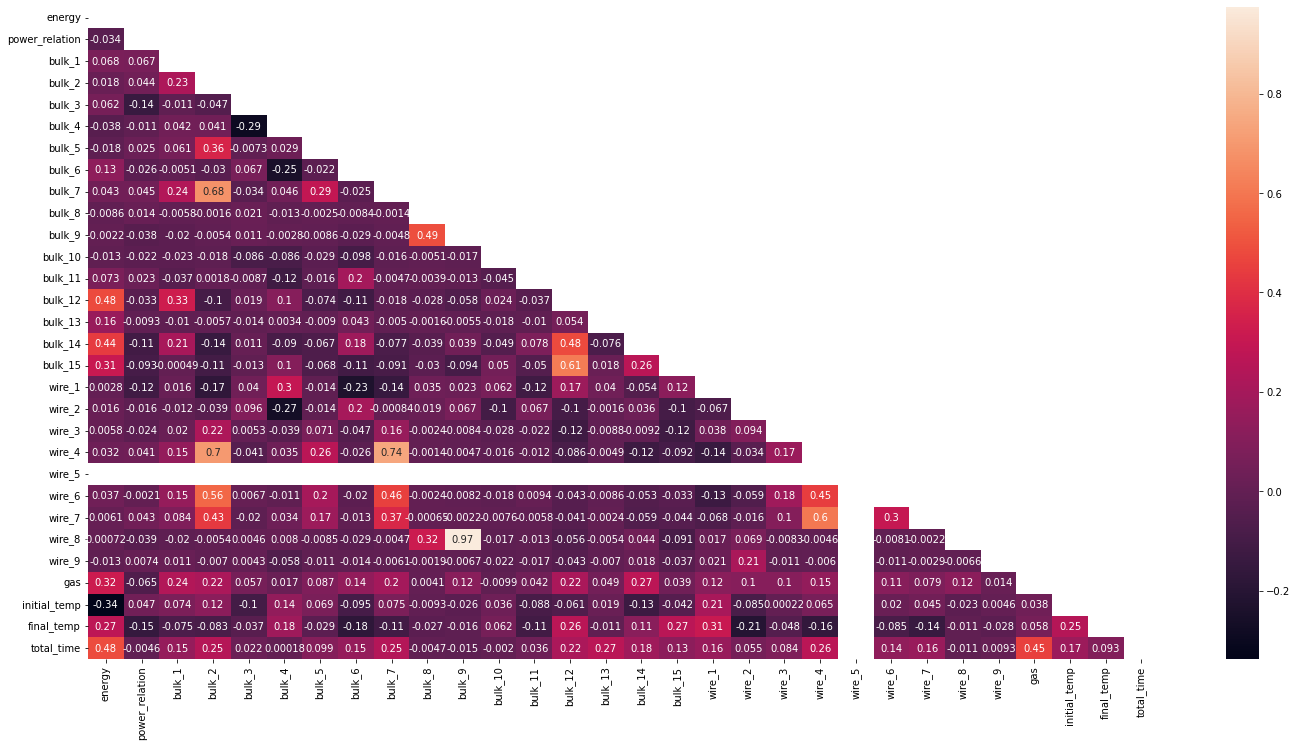

In [34]:
fig, ax = plt.subplots(figsize=(24, 12))
data_corr = data.drop(columns=['key']).corr()
sns.heatmap(data_corr, ax=ax, annot=True, mask=np.triu(np.ones_like(data_corr, dtype=bool))) 

На полученной карте видно, что:
- Присутствует только одна явная корреляция, между wire_8 и bulk_9. Это значит, что при добавлении одной из добавок всегда добавляют определенную проволоку. Не будем удалять эти значения, так как такое вполне возможно с точки зрения металлургического процесса.
- Кроме этого значения, не присутствует других сильно коррелируемых значений. Главнео, что отсутствуют сильные корреляции между полученными признаками и конеченой температурой, то есть нашей целевой переменной, а это значит, что у нас не наблюдается утечки признаков.

### Создание таблиц для обучения и тестирования

Разделим датасет на таблицу с признаками и целевой переменной.

In [35]:
X = data.drop(columns=['key', 'final_temp'])
y = data['final_temp']

Теперь разделим датасет на обучающую и тестовую выборки в соотношении 1:4.

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

Данные разделили, теперь будем обучать модели.

## Обучение моделей

Предлагается использовать различные модели для обучения, такие как линейная регрессия с регуляризацией, случайный лес и градиентный бустинг. Однако, для начала проверим случайную модель, которая всегда предсказывает среднее значение переменной. 

Также создадим датасет, в котором будем сравнивать время обучения, время предсказания и полученную метрику MAE на тестовой выборке.

In [37]:
results = pd.DataFrame({'model_name':[], 'train_time':[], 'predict_time':[], 'test_MAE':[]})

Напишем функцию, которая получает на вход нашу модель, тренировочный и тестовый датасет, и на выходе дает необходимые нам параметры.

In [38]:
def model_validation(model, params, X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test):
    
    output = []
    
    gs = GridSearchCV(estimator=model, param_grid=params, scoring='neg_mean_absolute_error', cv=5)
    gs.fit(X_train, y_train)
    
    best_model = gs.best_estimator_
    
    start_time = time.time()
    best_model.predict(X_test)
    end_time = time.time()
    prediction_time = end_time - start_time
    
    pred = best_model.predict(X_test)
    
    mae_test = mean_absolute_error(y_test, pred)
    
    output.append(best_model)
    output.append(gs.cv_results_['mean_fit_time'].mean())
    output.append(prediction_time)
    output.append(mae_test)
    
    return output

### Случайная модель

Создадим нашу модель и параметры, которые будем перебирать.

In [39]:
model_dummy = DummyRegressor()
params_dummy = {'strategy':['mean', 'median']}

results_dummy = model_validation(model_dummy, params_dummy)

Создадим на основе полученных данных датафрейм и посмотрим на полученные результаты.

In [41]:
results_dummy_df = pd.DataFrame(np.array(results_dummy).reshape(-1, 4), columns=results.columns)
results_dummy_df

,model_name,train_time,predict_time,test_MAE
0,DummyRegressor(strategy='median'),0.000799,0.0,7.439791


- Модель обучилась очень быстро, менее чем за секунду. 
- При этом оптимальное MAE в 7.44 на тестовой выборке было достигнуто при предсказывании медианного значения. Случайная модель сразу даёт нам 4sp. 
- Соответственно, остальные модели должны должны предсказывать лучше случайной. 

Добавим полученные данные в итоговый датафрейм и попробуем другие модели.

In [42]:
results = results.append(results_dummy_df, ignore_index=True)

C:\Users\Влад\AppData\Local\Temp\ipykernel_18588\3551985333.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(results_dummy_df, ignore_index=True)


### Линейная регрессия с регуляризацией

Используем модель Ridge. В процессе обучения проведем поиск оптимальных параметров.

In [44]:
model_rigde = Ridge()
params_ridge = {'alpha':[0.0, 0.5, 1, 10, 100, 1000]}

results_ridge = model_validation(model_rigde, params_ridge)

results_ridge_df = pd.DataFrame(np.array(results_ridge).reshape(-1, 4), columns=results.columns)
results_ridge_df

,model_name,train_time,predict_time,test_MAE
0,Ridge(alpha=1),0.003578,0.000999,6.125339


- Модель линейной регрессии с регуляризацией также очень быстро обучилась, за 3.6 мс. При этом значения она предсказала за 1 мс.
- Было достигнуто оптимальное MAE в 6.13 на тестовой выборке, что лучше, чем у случайной модели. Этот результат даёт нам 5.5sp. 

Добавим полученные данные в итоговый датафрейм и пойдем дальше.

In [45]:
results = results.append(results_ridge_df, ignore_index=True)

C:\Users\Влад\AppData\Local\Temp\ipykernel_18588\2137061616.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(results_ridge_df, ignore_index=True)


### Случайный лес

Обучим модель случайного леса, также перебирая различные параметры в процессе обучения.

In [46]:
model_rf = RandomForestRegressor(criterion='absolute_error')
params_rf = {'n_estimators':[10, 50, 100], 'max_depth':[10, 20, 30]}

results_rf = model_validation(model_rf, params_rf)

results_rf_df = pd.DataFrame(np.array(results_rf).reshape(-1, 4), columns=results.columns)
results_rf_df

C:\Users\Влад\AppData\Local\Temp\ipykernel_18588\712858558.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  results_rf_df = pd.DataFrame(np.array(results_rf).reshape(-1, 4), columns=results.columns)


,model_name,train_time,predict_time,test_MAE
0,(DecisionTreeRegressor(criterion='absolute_err...,5.34878,0.017994,5.667906


- Модель случайного леса обучалась в среднем за 5.35 секунд, и предсказала значения за 18 мс.
- Было достигнуто оптимальное MAE в 5.67 на тестовой выборке, что также лучше, чем у случайной модели. Этот результат даёт нам 6.0sp.

Добавим полученные данные в итоговый датафрейм и пойдем дальше.

In [47]:
results = results.append(results_rf_df, ignore_index=True)

C:\Users\Влад\AppData\Local\Temp\ipykernel_18588\2172578436.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(results_rf_df, ignore_index=True)


### Градиентный бустинг

Обучим модель градиентного бустинга.

In [48]:
model_gb = GradientBoostingRegressor(loss='absolute_error')

params_gb = {'learning_rate':[0.01, 0.1, 1.0], 'max_depth':[2, 4, 6]}

results_gb = model_validation(model_gb, params_gb)

results_gb_df = pd.DataFrame(np.array(results_gb).reshape(-1, 4), columns=results.columns)
results_gb_df

C:\Users\Влад\AppData\Local\Temp\ipykernel_18588\3741087507.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  results_gb_df = pd.DataFrame(np.array(results_gb).reshape(-1, 4), columns=results.columns)


,model_name,train_time,predict_time,test_MAE
0,([DecisionTreeRegressor(criterion='friedman_ms...,0.722764,0.002998,5.574764


- Модель градиентного бустинга обучалась в среднем за 0.72 секунд, и предсказала значения за 3 мс.
- Было достигнуто оптимальное MAE в 5.57 на тестовой выборке, что также лучше, чем у случайной модели. Этот результат даёт нам 6.0sp.

Добавим полученные данные в итоговый датафрейм и посмотрим на него.

In [49]:
results = results.append(results_gb_df, ignore_index=True)

C:\Users\Влад\AppData\Local\Temp\ipykernel_18588\3260977398.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(results_gb_df, ignore_index=True)


Видно, что оптимальной моделью в нашем случае является градиентный бустинг, так как она обучается менее секунды, предсказывает значения за 3 мс и обладает метрикой MAE на тестовой выборке 5.45.

### Проверка важности параметров

Посмотрим, какие признаки в случае самой оптимальной модели - градиентного бустинга, являются самыми важными.

Для этого сначала обучим модель с оптимальными параметрами.

In [50]:
gb = results['model_name'][3]

gb.fit(X_train, y_train)

GradientBoostingRegressor(loss='absolute_error', max_depth=4)

Теперь извлечем важность признаков в отдельную таблицу.

In [51]:
feature_importances = pd.DataFrame({'feature':X_train.columns, 'importance':gb.feature_importances_}).sort_values(by='importance', ascending=False)

Построим соответствующий график.

<AxesSubplot:xlabel='importance', ylabel='feature'>

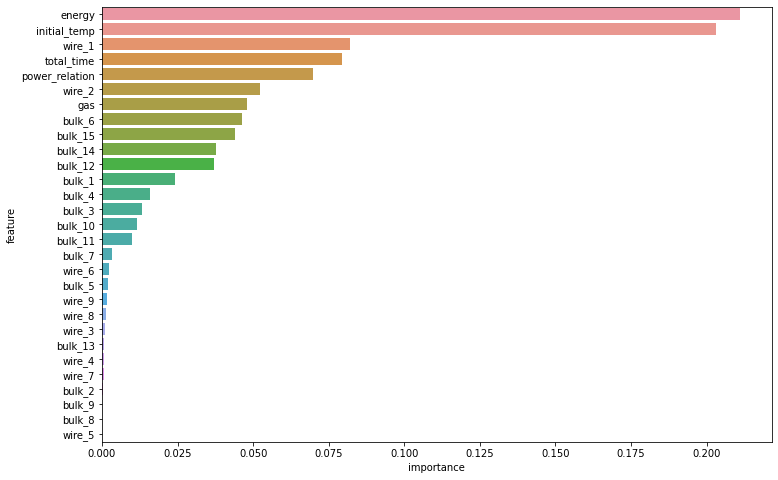

In [52]:
fig, ax = plt.subplots(figsize=(12, 8))
sns.barplot(data=feature_importances, y='feature', x='importance', ax=ax)

Видно, что в нашем случае самыми важными параметрами являются:
- Общая энергия.
- Начальная температура.

## Общий вывод

В данной работе для уменьшения энергопотребления нам необходимо было построить модель, которая предскажет температуру стали:
- Были загружены все данные.
- Проведен исследовательский анализ всех датасетов на предмет корреляции признаков друг с другом. Было выявлено, что в датасете отсутсвуют явно коррелирующие признаки.
- Затем был проведен процесс генерации признаков из всех датасетов и создание общей таблицы, на которой проводилось обучение моделей.
- Было обучено четыре различных модели, в том числе модель, которая каждый раз предсказывает медианное значение.
- Оптимальной моделью оказалась модель градиентного бустинга, которая предсказывала обучалась в среднем за менее чем 1 секунду и предсказывала значения за 3 мс. Данная модель показала минимальное значение MAE в 5.52.
- Случайная модель обладала MAE 7.5, что говорит о том, что наша модель предсказывает значения лучше случайной.
- Анализ важности признаков градиентного бустинга показал, что самыми важными признаками являются общая энергия, начальная температура, общее время выдержки и отношение между реактивной и активной мощностями.

# Отчет по решению

В данном отчете нам ответим на следующие вопросы:
- **Какие пункты плана были выполнены, а какие — нет (поясните почему)?**

Все пункты плана были выполнены, так как план состоял в основном из правильной подготовки данных к обучению. Так как были достигнуты необходимые метрики, можно сказать, что предобработка прошла успешно.


- **Какие трудности возникли и как вы их преодолели?**

Основной трудностью было именно понимание процесса обработки стали, чтобы понять, что значат те или иные параметры. Эту проблему я преодолел путем знакомства с процессом обработки, и проверки того, что значат те или иные параметры (активная, реактивная мощности и т.д.).

Второй проблемой была правильная подготовка данных для обучения модели. Для этого необходимо было провести различные расчёты для создания необходимых для обучения признаков. Эту проблему я также преодолел путем чтения литературы по обработке стали.

- **Какие ключевые шаги в решении задачи выделили?**

В ходе выполнения проекта я понял, что ключевым шагом является понимание процесса, который необходимо моделировать, так как это позволит правильно провести подготовку данных для обучения модели. Последняя тоже является ключевым шагом, так как будет определять возможность достижения необходимых метрик.

- **Какая ваша итоговая модель и какое у неё качество?**

В процессе выполнения проекта были обучены четыре различные модели: случайная модель, линейная регрессия с регуляризацией, случайный лес и градиентный бустинг.

Оптимальной моделью оказалась модель градиентного бустинга, так как в среднем она обучалась за 0.72 секунды, предсказывала значения не тестовой выборке за 3 мс и обладала итоговым MAE в 5.5.